# PyTransit tutorial 1: Modelling a single broadband transit light curve

## Introduction

This notebook is a first part of a set of tutorials teaching how to use *PyTransit* to model exoplanet transit light curves. We do this in a Bayesian parameter estimation setting where our main goal is to estimate the posterior densities for the model parameters. Here we consider the most simple case possible: modelling a single broadband transit light curve.

## Pytransit installation

The transit modelling is carried out with [*PyTransit*](https://github.com/hpparvi/PyTransit) that can be installed easily using pip:

    pip install pytransit
  
## Prior knowledge
  
What comes to assumed prior knowledge, well... I assume you already know the basics of Bayesian statistics, Python (and especially the scientific packages such as SciPy and NumPy), have a rough idea of MCMC sampling (and how *emcee* works), and, especially, have the grasp of basic concepts of transiting exoplanets and photometric time series.

In [1]:
%matplotlib inline 

In [2]:
import seaborn as sb
import pandas as pd

from numpy import percentile
from matplotlib import rc
from matplotlib.pyplot import subplots, setp
from corner import corner
from pytransit import TransitAnalysis, create_mock_light_curve

rc('figure', figsize=(13,5))

## Creation of a mock light curve

First, let's create a mock light curve of a hot Jupiter transit over a Sun-like star observed in the TESS passband. We use the `create_mock_light_curve` function from `pytransit` that can simulate transit light curves. The function returns two `ndarray`s, time and flux, that contain the mid-exposure times and flux values, respectively, and a dictionary containing the true values for the planet's geometric and orbital parameters.

In [3]:
time, flux, true_pars = create_mock_light_curve(texp=60, passband='TESS', noise=3e-4, transit_pars={'period':2.3})

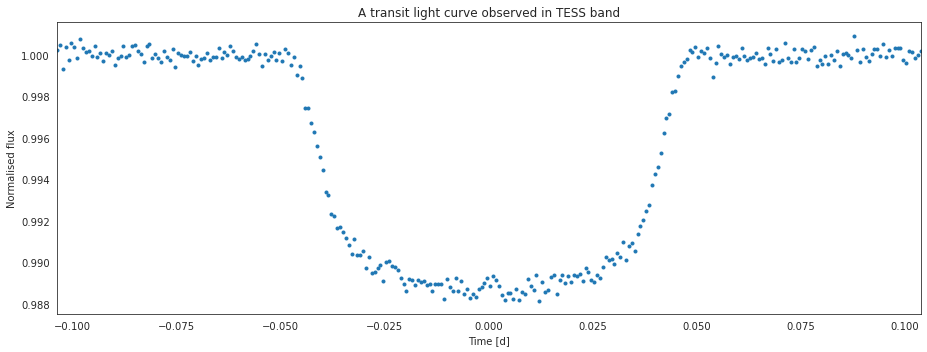

In [4]:
with sb.axes_style('white'):
    fig, ax = subplots()
    ax.plot(time, flux, '.')
    setp(ax, xlim=time[[0,-1]], title='A transit light curve observed in TESS band',
         xlabel='Time [d]', ylabel='Normalised flux')
    fig.tight_layout()

The `true_pars` dictionary contains the truth values: `t0` is the zero epoch, `period` is the orbital period, `ror` is the planet-star radius ratio, `rho` is the stellar density in g/cm$^3$, `b` is the impact parameter, `ecc` is the eccentricity, `omega` is the argument of periastron, `aor` is the orbital semi-major axis divided by the stellar radius, and `inc` is the inclination.

In [5]:
true_pars

{'t0': 0.0,
 'period': 2.3,
 'ror': 0.1,
 'rho': 1.5,
 'b': 0.5,
 'ecc': 0.0,
 'omega': 0.0,
 'aor': 7.4857675546236235,
 'inc': 1.5039531440774938}

These values will be useful later when we want to check how well our parameter estimates agree with the true values.

## Parameter estimation

First, we create an instance of the `TransitAnalysis` class. We initialize the class with an analysis `name` that will be used when saving the posterior samples, a set of passband names (or in our case, only the name for our single passband), the array of mid-exposure times, and the array of flux measurements.

In [6]:
ta = TransitAnalysis(name='tutorial_1', passbands='TESS', times=time, fluxes=flux)

During the initialization, the `TransitAnalysis` class checks the input data and various initialization arguments, and sets up the model parametrization. We can print the parameters, their prior distributions (priors from now on), and boundaries as

In [7]:
ta.print_parameters(1)

  0 |G| rho            U(a = 0.1, b = 25.0)                     [    0.00 ..      inf]
  1 |G| tc_1           N(μ = 0.0, σ = 0.1)                      [    -inf ..      inf]
  2 |G| p_1            N(μ = 1.0, σ = 1e-05)                    [    0.00 ..      inf]
  3 |G| b_1            U(a = 0.0, b = 1.0)                      [    0.00 ..      inf]
  4 |G| k2_1           U(a = 0.0004, b = 0.04000000000000001)   [    0.00 ..      inf]
  5 |G| secw_1         N(μ = 0.0, σ = 1e-05)                    [   -1.00 ..     1.00]
  6 |G| sesw_1         N(μ = 0.0, σ = 1e-05)                    [   -1.00 ..     1.00]
  7 |P| q1_TESS        U(a = 0, b = 1)                          [    0.00 ..     1.00]
  8 |P| q2_TESS        U(a = 0, b = 1)                          [    0.00 ..     1.00]
  9 |L| wn_loge_0      U(a = -4, b = 0)                         [    -inf ..      inf]


This is the most simple parametrization for `TransitAnalysis`. We initialize the class with only one light curve, and the analysis class assumes that our system contains only a single transiting planet by default. The parameters are

- `rho` is the stellar density in g/cm$^3$
- `tc_1` is the zero epoch for planet 1
- `p_1` is the period for planet 1
- `b_1` is the impact parameter for planet 1
- `k2_1` is the planet-star area ratio ($k^2$ where $k$ is the radius ratio) for planet 1
- `secw_1` is $\sqrt{e} \cos\omega$ for planet 1, where $e$ is the eccentricity and $\omega$ is the argument of periastron
- `sesw_1` is $\sqrt{e} \sin\omega$ for planet 1, where $e$ is the eccentricity and $\omega$ is the argument of periastron
- `q1_TESS` is the first quadratic limb darkening coefficient in the Kipping et al (2012) triangular parametrisation for the TESS passband
- `q2_TESS` is the second quadratic limb darkening coefficient in the Kipping et al (2012) triangular parametrisation for the TESS passband
- `wn_loge_0` is $\log_{10}$ average white noise standard deviation for the first (and only) light curve


## Set the parameter priors

The priors set on the parameters are printed after the parameter name. The default parametrization uses only two priors: (U)niform and (N)ormal. The default values are ok for most of the parameters in our example case (for example, we assume a circular orbit since both `secw_1` and `sesw_1` have tight zero-centered normal priors). The only major exception is the orbital period. We can't derive the orbital period from a single transit (unless we know the stellar density and orbital eccentricity well), but we can assume we have prior information about the true orbital period from other sources.

We can change the prior using the `set_prior` method that takes the parameter name, prior abbreviation, and prior values (in its simplest form, you can also give it a prior object). Let's give the period a normal prior with a mean corresponding to the true period and the standard deviation marking a relatively small uncertainty.

In [8]:
ta.set_prior('p_1', 'NP', 2.3, 0.001)

In [9]:
ta.print_parameters(1)

  0 |G| rho            U(a = 0.1, b = 25.0)                     [    0.00 ..      inf]
  1 |G| tc_1           N(μ = 0.0, σ = 0.1)                      [    -inf ..      inf]
  2 |G| p_1            N(μ = 2.3, σ = 0.001)                    [    0.00 ..      inf]
  3 |G| b_1            U(a = 0.0, b = 1.0)                      [    0.00 ..      inf]
  4 |G| k2_1           U(a = 0.0004, b = 0.04000000000000001)   [    0.00 ..      inf]
  5 |G| secw_1         N(μ = 0.0, σ = 1e-05)                    [   -1.00 ..     1.00]
  6 |G| sesw_1         N(μ = 0.0, σ = 1e-05)                    [   -1.00 ..     1.00]
  7 |P| q1_TESS        U(a = 0, b = 1)                          [    0.00 ..     1.00]
  8 |P| q2_TESS        U(a = 0, b = 1)                          [    0.00 ..     1.00]
  9 |L| wn_loge_0      U(a = -4, b = 0)                         [    -inf ..      inf]


### Optimization

We start the parameter estimation by finding the set of parameters that maximize the posterior distribution.

Global optimisation:   0%|          | 0/500 [00:00<?, ?it/s]

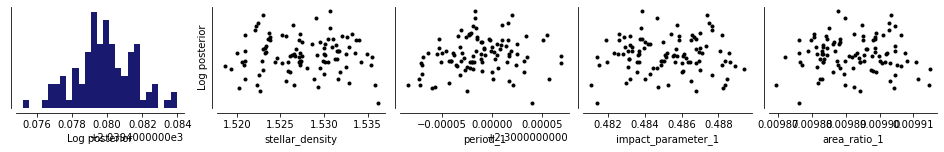

In [10]:
ta.optimize_global(niter=500, npop=100)

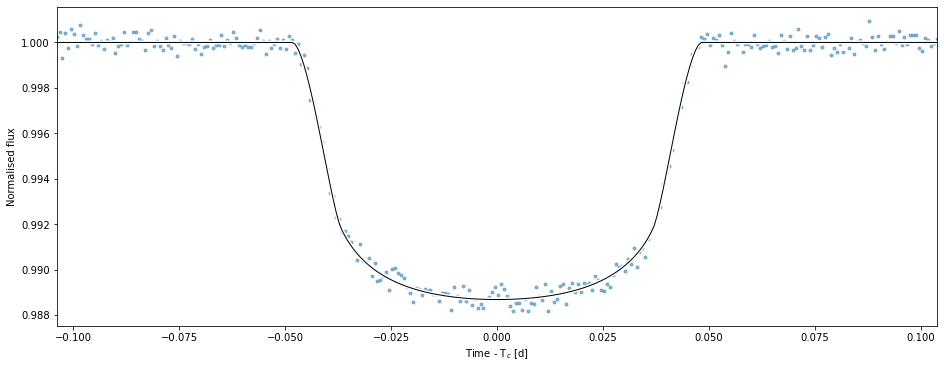

In [11]:
ta.plot_light_curves('fit');

### Posterior estimation

In [12]:
ta.sample_mcmc(niter=2000, thin=20, repeats=3)

MCMC sampling:   0%|          | 0/3 [00:00<?, ?it/s]

Run 1/3:   0%|          | 0/2000 [00:00<?, ?it/s]

Run 2/3:   0%|          | 0/2000 [00:00<?, ?it/s]

Run 3/3:   0%|          | 0/2000 [00:00<?, ?it/s]

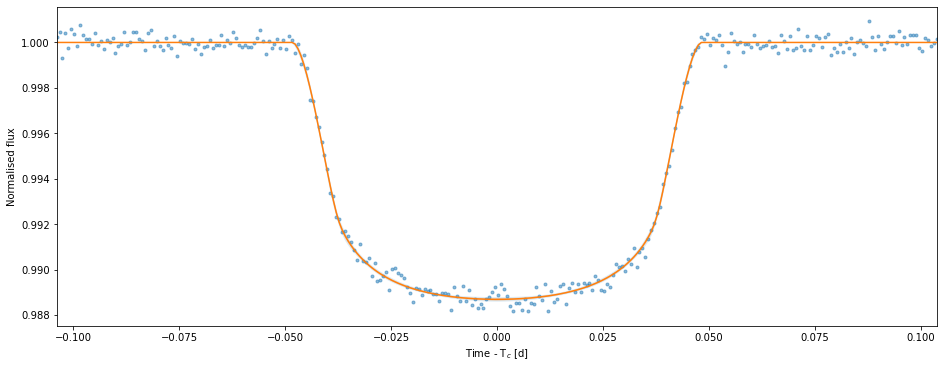

In [13]:
ta.plot_light_curves('posterior');

### Analysis: overview

The MCMC chains are now stored in ``lpf.sampler.chain``. Let's first have a look into how the chain populations evolved to see if we have any problems with our setup, whether we have converged to sample the true posterior distribution, and, if so, what was the burn-in time.

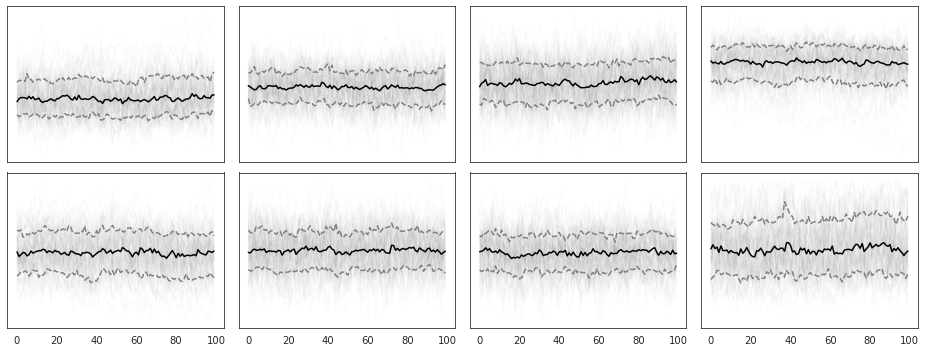

In [14]:
with sb.axes_style('white'):
    fig, axs = subplots(2,4, figsize=(13,5), sharex=True)
    ls, lc = ['-','--','--'], ['k', '0.5', '0.5']
    percs = [percentile(ta.sampler.chain[:,:,i], [50,16,84], 0) for i in range(8)]
    [axs.flat[i].plot(ta.sampler.chain[:,:,i].T, 'k', alpha=0.01) for i in range(8)]
    [[axs.flat[i].plot(percs[i][j], c=lc[j], ls=ls[j]) for j in range(3)] for i in range(8)]
    setp(axs, yticks=[])
    fig.tight_layout()

Ok, everything looks good. The 16th, 50th and 84th percentiles of the parameter vector population are stable and don't show any significant long-term trends. Now we can flatten the individual chains into one long chain ``fc`` and calculate the median parameter vector.

## Analysis

We start the analysis by making a Pandas data frame ``df``, using the ``df.describe`` to gen an overview of the estimates, and plotting the posteriors for the most interesting parameters as violin plots.

In [15]:
df = ta.posterior_samples()

In [16]:
df

Inference data with groups:
	> posterior
	> sample_stats
	> derived_parameters

While we're at it, let's plot some correlation plots. The limb darkening coefficients are correlated, and we'd also expect to see a correlation between the impact parameter and radius ratio.

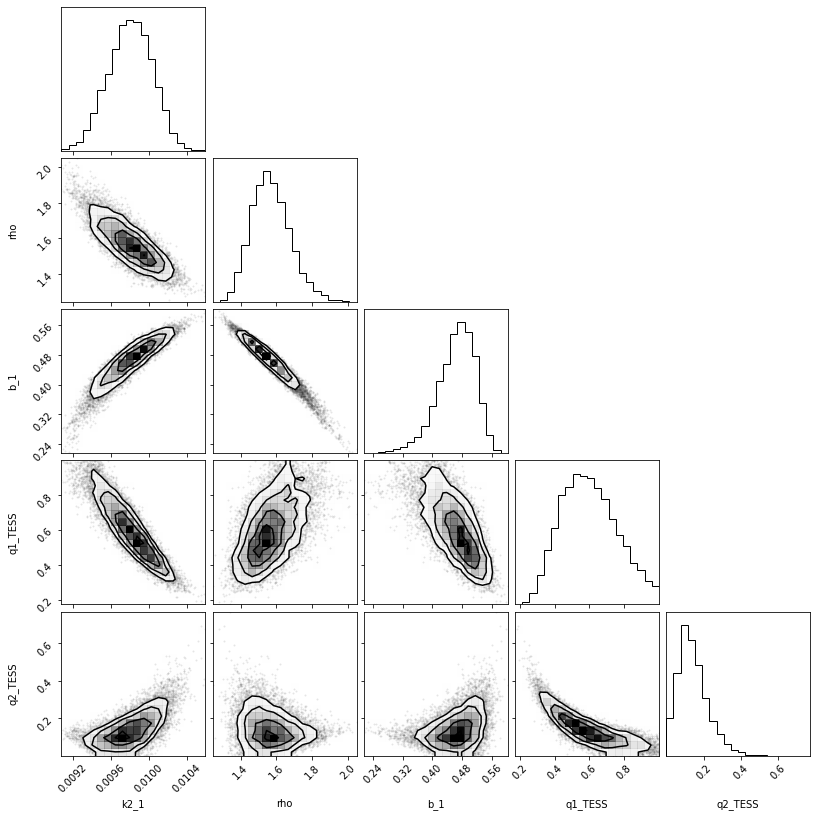

In [17]:
corner(df.posterior[['k2_1', 'rho', 'b_1', 'q1_TESS', 'q2_TESS']]);

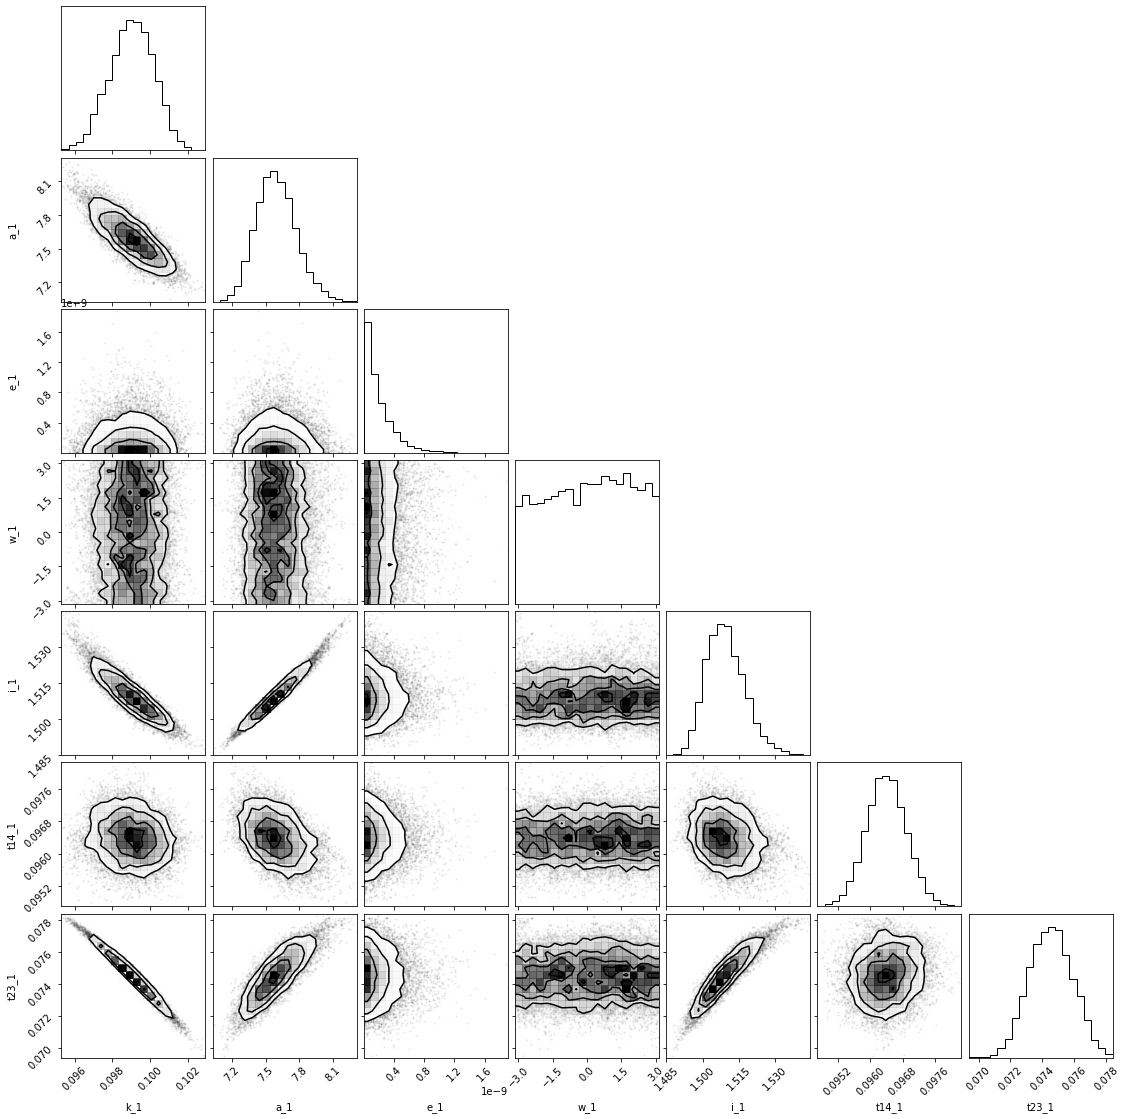

In [18]:
corner(df.derived_parameters);

---
<center>&copy; Hannu Parviainen 2022</center>